# **ABOUT DATA**

A daily time-series of commodity futures for 23 different commodities from 2000 until present. All prices are quoted in Euros. The sub-categories falls under the following categories: Energy, Industrial Metal, Precious Metal, Grains, Livestocks, Softs. For analysis purpose, the core focus will be on the Grain category. The subcategories in this category include: 

1. Grains

    - Corn: quoted in EUR/bushel.

    - Soybeans: quoted in EUR/bushel.

    - Wheat: quoted in EUR/bushel.

    - Soybean Oil: quoted in EUR/lb.

    - Soybean Meal: quoted in EUR/T.

    - HRW Wheat: quoted in EUR/bushel.

In [1]:
import pandas as pd

commodities = pd.read_csv('data/commodity_futures.csv', 
                          parse_dates=['Date'], 
                          index_col='Date')

col_grains = ['CORN', 'SOYBEAN OIL', 'SOYBEAN MEAL', 
              'SOYBEANS', 'WHEAT', 'HRW WHEAT']
grains = commodities[col_grains]
grains.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5863 entries, 2000-01-03 to 2022-09-16
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CORN          5863 non-null   float64
 1   SOYBEAN OIL   5863 non-null   float64
 2   SOYBEAN MEAL  5863 non-null   float64
 3   SOYBEANS      5863 non-null   float64
 4   WHEAT         5863 non-null   float64
 5   HRW WHEAT     5863 non-null   float64
dtypes: float64(6)
memory usage: 320.6 KB


## Overall Interpretation

1. Soybeans has the record high prices while soybean oil has the record low prices. 

2. HRW wheat and wheat have similar prices across the years.

3. All the grain commodities experienced high prices around 2008, and low prices between 2015 and 2020.


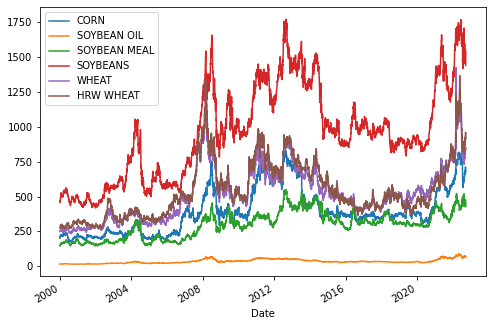

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5.5))
grains.plot(ax=ax);

# **TECHNICAL NOTES**

Before beginning the analysis, let's clarify on some technical terms

## ARIMA Model

Autoregressive integrated moving average model is a combination of autoregressive model and moving average model. Before looking at the ARMA model let's break it down.

### Autoregressive Model

An autoregressive model regresses the values of the time series against previous values of the same time series:

$$y_t = a_1y_{t-1} + \cdots + a_py_{t-p} + \epsilon_t$$

Where:

- $y_t$ is the value of the particular time series at time $t$

- $a_1 \cdots a_p$ are the autoregressive coefficients at lag $1 \cdots p$

- $y_{t-1} \cdots y_{t-p}$ are the values of the time series at the previous steps

- $\epsilon_t$ is the shock term which is a white noise, i.e., each shock is random and not related to the other shock in the series.

### Moving Average Model

A moving average model regresses the value of the time series against the previous shock value of the same time series:

$$y_t = m_1\epsilon_{t-1} + \cdots + m_q\epsilon_{t-q} + \epsilon_t$$

Where:

- $y_t$ is the value of the particular time series at time $t$

- $m_1 \cdots m_q$ are the moving average coefficients at lag $1 \cdots q$

- $\epsilon_{t-1} \cdots \epsilon_{t-q}$ are the values of the shock at the previous steps.

- $\epsilon_t$ is the shock term for the current step.

## Picking Model Order

Before fitting an ARIMA model, it is important to understand how to pick the right model order because the right model orders gives a better fitting models which makes better predictions. For this task, the autocorrelation function (ACF) and partial autocorrelation function (PACF) will be used. Autocorrelation function is the set of correlation values for different lags while PACF is the correlation associated with just a particular lag. The table below provides a rough idea of how to choose the model order.

![](info/ACF_PACF.png)

Alternatively, there is the use Akaike information criteria (AIC) or Bayesian information criteria (BIC). AIC penalizes models with lots of parameters. That is, if the set order is too high compared to the data, the AIC value will be high hence stopping overfitting to the training data. Note that low AIC have better predictions. BIC on the other hand penalize overly complex models, that is, it choses simple models with lower order. If the goal is to identify a good predictive model, AIC is used while if the goal is to identify a good explanatory model, BIC is considered. 

## Model Diagnostic

With the model order in place, the next step is to perform a model diagnostic which will help check if the model is behaving well. One of the ways to diagnose the model is to get the residual from the training data. These are the difference between the model's one-step-ahead prediction and the real values of the time series. From the residuals the mean absolute error (MAE) can be obtained. MAE helps explain how large the residuals are and so how far the prediction are from the true values.  Another way is to use the plot diagnostic which has four plots: the residual plot, histogram plus estimated density plot, normal q-q plot, and correlogram plot. Finally, there are the summary statistics like Prob(Q) - Ljung-Box - and Prob(JB) - Jarque-Bera.

## Seasonality Check

Now it's time to check if the data has a predictable pattern that repeats, yearly, weekly, daily, monthly or hourly. Being that time series are made of a trend, a seasonal component, and residuals, seasonal decomposition is used. However, decomposing the data requires the knowledge of the cycle repeats and for this, guessing can be done or applying the ACF. In the case where the time series is non-stationary and for a clear ACF plot detrending is necessary. Detrending can be done by taking the difference. However, when checking for period, the rolling mean is what is used.

# **SOYBEANS ANALYSIS**



Being that the index of the DataFrame has been transformed to a `PeriodIndex` `.loc[]` will be used to do positional indexing insted of `.iloc[]`

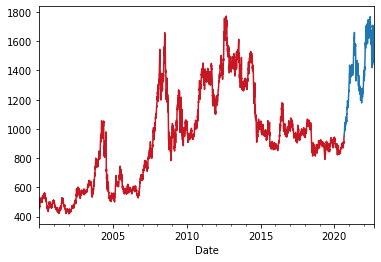

In [3]:
soybeans_data = grains['SOYBEANS']
soybeans_data.index = (pd.DatetimeIndex(soybeans_data.index)
                      .to_period('D'))

soybeans_train = soybeans_data.loc[:'2020-08-31']
soybeans_test = soybeans_data.loc['2020-09-01':]

soybeans_train.plot(color='#c81722')
soybeans_test.plot();

## Stationarity Check

Before creating a time series model, the data is checked to see if it is stationary.

### Visually

By the look of the plot, the data is not stationary because there is somewhat a positive trend. The shock terms or jumps do not appear to be the same size throughout the soybean time series.

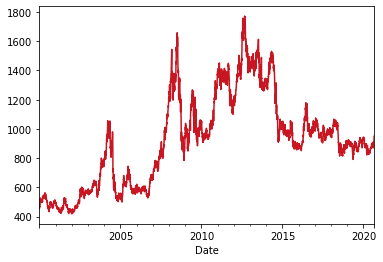

In [4]:
soybeans_train.plot(color='#c81722');

Checking at the percentage increase of price per day (return), the variance change with time hence the returns are not stationary.

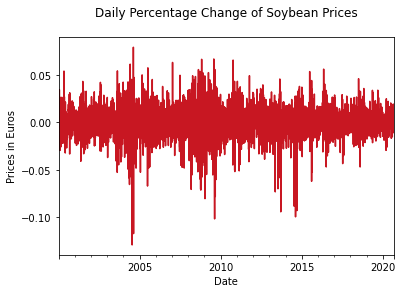

In [5]:
(soybeans_train
 .pct_change(fill_method='ffill')
 .plot(color='#c81722'))
plt.title('Daily Percentage Change of Soybean Prices\n')
plt.ylabel('Prices in Euros');

### Statistically 

The augmented Dicky-Fuller (ADF) test test for trend stationarity. Its null hypothesis states that the time series is non-stationary due to trend. When used in this case, the test statistic is -2.172, the test p-value is 0.217 and from the critical value if the p-value was to be 0.05 or below, the test statistic needed to be -2.862. Therefore, the soybean time series is non-stationary. The result is also supported by the first plot.

In [6]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    """Input a DataFrame to get ADF results"""
    df_adf = adfuller(df)
    print('Test Statistics: ', df_adf[0])
    print('p-value: ', df_adf[1])
    print('Critical value at 5%: ', df_adf[4]['5%'])
    
adf_test(soybeans_train)

Test Statistics:  -2.171985395581761
p-value:  0.2165697703885543
Critical value at 5%:  -2.862083235058105


## Changing to Stationary

Changing a non-stationary time series into stationary form before model it can be seen as feature engineering. 

### Differencing 

Here the first difference of soybean is taken. That is, for each value in the time series, the previous value is subtracted. Being that the first value is recorded as `NaN`, because there is no previous to subtract from it, it is dropped before creating a plot.

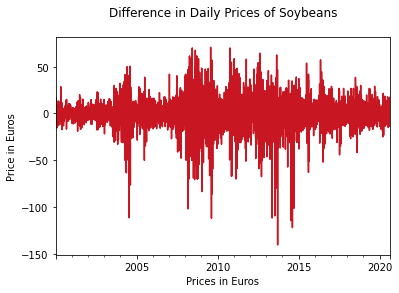

In [7]:
soybeans_diff = soybeans_train.diff().dropna()
soybeans_diff.plot(color='#c81722')
plt.ylabel('Price in Euros')
plt.title('Difference in Daily Prices of Soybeans\n')
plt.xlabel('Prices in Euros');

After plotting the difference, ADF is used to check if the "differenced" time series is stationary. This time the null hypothesis is rejected because of the very significant p-value; hence, the series is stationary.

In [8]:
adf_test(soybeans_diff)

Test Statistics:  -22.995138021522763
p-value:  0.0
Critical value at 5%:  -2.862083235058105


### Log Return Transformation

Log return is a classic way to transform stock time series and is calculated using the formula below:

$$log\left(\frac{y_t}{y_{t-1}}\right)$$  

Where, $y_t$ is the time series and $y_{t-1}$ is the shift from the previous price.

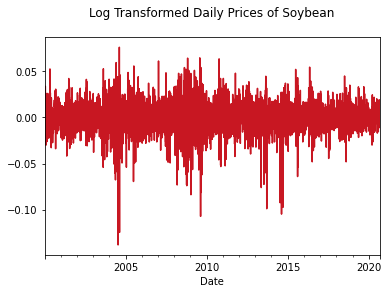

In [9]:
import numpy as np

soybeans_log = (np.log(soybeans_train/
                       soybeans_train.shift(1))
               .dropna())

soybeans_log.plot(color='#c81722')
plt.title('Log Transformed Daily Prices of Soybean\n');

It is noticeable that both the differenced and log-return transformed soybean time series have small p-values. However, the log transformed series has a much more negative test statistics. The more the negative the test statistic the more likely that the data is stationary. Despite, log return method giving the best method, further studies have to be done on how this data can be back-transformed. Therefore, onwards the `soybean_diff` data will be used due to ease in back-transformation.

In [10]:
adf_test(soybeans_log)

Test Statistics:  -23.0740980689041
p-value:  0.0
Critical value at 5%:  -2.862083235058105


## Stationarity Check

Check for the periods reveals that the data has no obvious seasonality. For now, the decision is that there is no seasonality. However, further investigations is being undertaken to come up with a conclusive stand.

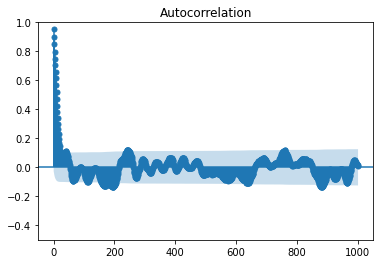

In [150]:
from statsmodels.graphics.tsaplots import plot_acf

soybeans_roll = (soybeans_train 
                 - soybeans_train
                 .rolling(30)
                 .mean()).dropna()

plot_acf(soybeans_roll, lags=1000, zero=False)
plt.ylim(-0.5);

## Selecting Model Order

Before fitting an ARIMA model, it is important to understand how to pick the right model order because the right model orders gives a better fitting models which makes better predictions.

### Using ACF and PACF Plots

In this case, choosing a model order from both the ACF and PACF plots is easy because they cuts off at the first lag this makes model orders to be zero. This conclusion may mean that the data is white noise so it is best if another method is tried.

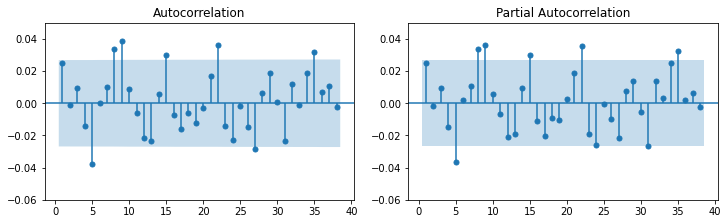

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3), 
                            constrained_layout=True)

plot_acf(soybeans_diff, zero=False, ax=ax0)
ax0.set_ylim(-0.06, 0.05)

plot_pacf(soybeans_diff, zero=False, ax=ax1, method='ywm')
ax1.set_ylim(-0.06, 0.05);

### Using AIC & BIC

The AIC and BIC are another way of determining the model order. One easy way of performing this task is by using the `pmdarima` package which also gives similar results.

In [12]:
import pmdarima as pm

pm.auto_arima(soybeans_train, d=1)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Before coming to a conclusion the traditional for loop method is used. Surprisingly, the order is 2,4 if considering AIC and 0,0 is considering BIC. Since AIC provides a good predictive model, it is chosen.

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from warnings import filterwarnings
filterwarnings('ignore')

soybeans_vals = []
cols = ['p', 'q', 'aic', 'bic']

for p in range(5):
    for q in range(5):
        model = SARIMAX(soybeans_train, order=(p,1,q)).fit()
        soybeans_vals.append((p, q, model.aic, model.bic))
        
soybeans_vals_df = pd.DataFrame(soybeans_vals, 
                                columns=cols)
print(soybeans_vals_df.sort_values('aic').head())

    p  q           aic           bic
14  2  4  44368.994782  44415.063841
13  2  3  44369.450295  44408.938060
22  4  2  44369.547700  44415.616759
18  3  3  44371.244988  44417.314047
23  4  3  44373.177159  44425.827512


From now on, the model to be used is defined below: ARIMA(2,0,4). That is, 2 and 4 lag coefficients of AR and MA and an error term (`sigma2`) of 240.4


In [14]:
soybeans_model = (SARIMAX(soybeans_train, 
                         order=(2,1,4), 
                          trend='c')
                  .fit())

print(soybeans_model.summary())

                               SARIMAX Results                                
Dep. Variable:               SOYBEANS   No. Observations:                 5332
Model:               SARIMAX(2, 1, 4)   Log Likelihood              -22177.432
Date:                Thu, 22 Sep 2022   AIC                          44370.865
Time:                        10:05:48   BIC                          44423.515
Sample:                    01-03-2000   HQIC                         44389.258
                         - 08-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0635      0.200      0.318      0.750      -0.328       0.455
ar.L1          1.0688      0.012     92.876      0.000       1.046       1.091
ar.L2         -0.9435      0.011    -85.240      0.0

## Model Diagnostic

With the model order in place it time to perform a model diagnostic to check if the model is behaving well

### Mean Absolute Error

The mean error is about 10 euros per day.

In [15]:
np.mean(np.abs(soybeans_model.resid))

10.257079871376758

### Plot Diagnostics

There is no obvious patterns in the standardized residual plot. The KDE and normal distribution plots are different. The normal Q-Q plot shows that the residuals are not normally distributed and in the correlogram shows the existence of significant correlation in residuals which means that there is information in the data that our model hasn't captured.  

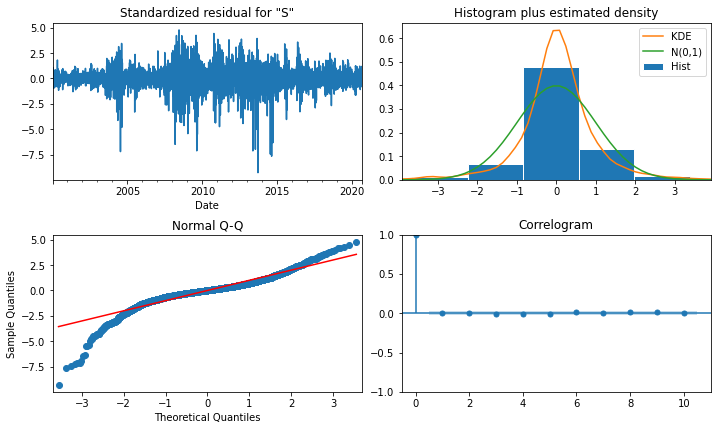

In [16]:
fig = soybeans_model.plot_diagnostics(figsize=(10, 6))
fig.tight_layout(pad=0.8);

### Summary Statistics

The null hypothesis that the residuals have no correlation pattern is accepted, Prob(Q)=0.99. Contrarily, the null hypothesis that the residual are Gaussian normally distributed is rejected, Prob(JB)=0.00.

## Decision

Using the information gathered, from the statistical tests and plots from diagnostic step, the decision is to proceed by making a forecast. Should there be any information that suggest otherwise, the work will be subject to change. 

## Forecasting

Predicting the future will be done using the model created.

### One-Step-Ahead Predictions

Before making future predictions, it is good to evaluate how good the model is at predicting values ahead. When making a one-step-ahead prediction, the central value of the predictions are generated together with the confidence intervals of these values. In this case study, the in-sample prediction are made for approximately the last 2 years.

In [17]:
soybeans_prediction = (soybeans_model
                      .get_prediction(start=-600, 
                                      dynamic=True))

soybeans_forecast = (soybeans_prediction
                    .predicted_mean)

soybeans_ci = (soybeans_prediction
              .conf_int())

These values are then used to plot the in-sample prediction which as can be seen from the results estimates that the error prediction will be within the range of the actual prices.

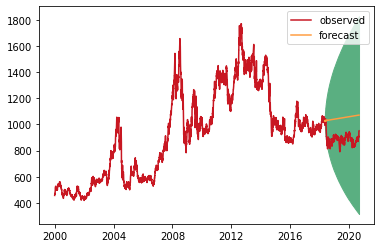

In [18]:
plt.plot(soybeans_train.index.to_timestamp(), 
         soybeans_train, 
         color='#c81722', 
         label='observed')

plt.plot(soybeans_forecast.index.to_timestamp(), 
         soybeans_forecast, 
         label='forecast', 
         color='#ff9d41')

plt.fill_between(soybeans_ci.index.to_timestamp(), 
                 soybeans_ci['lower SOYBEANS'], 
                 soybeans_ci['upper SOYBEANS'], 
                 color='#5aaf81')
plt.legend();

### Forecasting Out-of-Sample

After testing the predictions in-sample, the model can be used to predict the future. In this case, up to the end of 2022. From the predictions the price is on an increasing trend

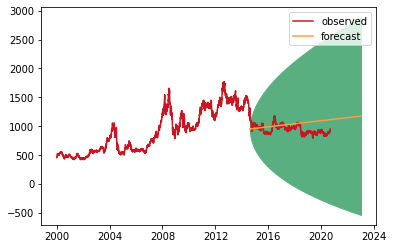

In [29]:
soybeans_prediction = (soybeans_model
                       .get_forecast(steps='2022-12-31'))
soybeans_forecast = soybeans_prediction.predicted_mean
soybeans_ci = soybeans_prediction.conf_int()

plt.plot(soybeans_train.index.to_timestamp(), 
         soybeans_train, 
         color='#c81722', 
         label='observed')

plt.plot(soybeans_forecast.index.to_timestamp(), 
         soybeans_forecast, 
         label='forecast', 
         color='#ff9d41')

plt.fill_between(soybeans_ci.index.to_timestamp(), 
                 soybeans_ci['lower SOYBEANS'], 
                 soybeans_ci['upper SOYBEANS'], 
                 color='#5aaf81')
plt.legend();

# HRW WHEAT



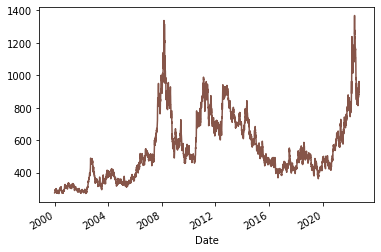

In [23]:
grains['HRW WHEAT'].plot(color='#865549');

In [24]:
pm.auto_arima(grains['HRW WHEAT'].diff().dropna())

ARIMA(order=(3, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

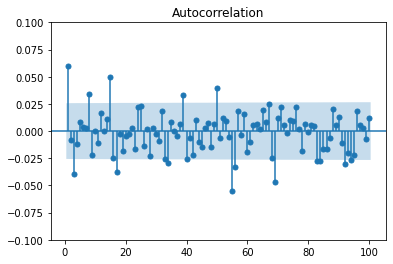

In [152]:
plot_acf(grains['HRW WHEAT'].diff().dropna(), zero=False, lags=100)
plt.ylim(-0.1, 0.1);

# WHEAT



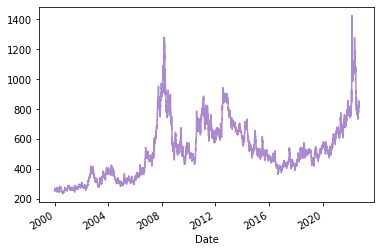

In [25]:
grains['WHEAT'].plot(color='#ac8ad1');

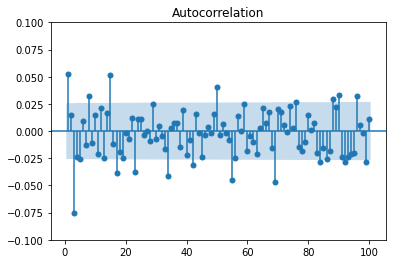

In [153]:
plot_acf(grains['WHEAT'].diff().dropna(), zero=False, lags=100)
plt.ylim(-0.1, 0.1);

# CORN



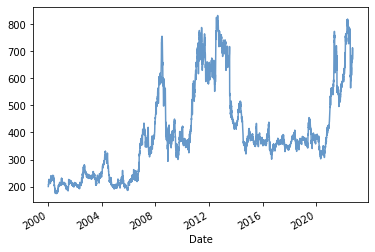

In [26]:
grains['CORN'].plot(color='#6698c9');

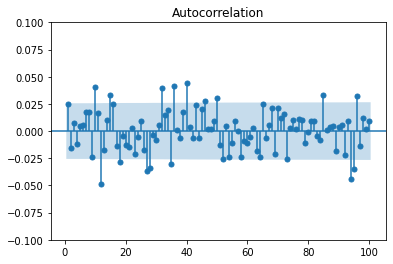

In [154]:
plot_acf(grains['CORN'].diff().dropna(), zero=False, lags=100)
plt.ylim(-0.1, 0.1);

# SOYBEAN MEAL



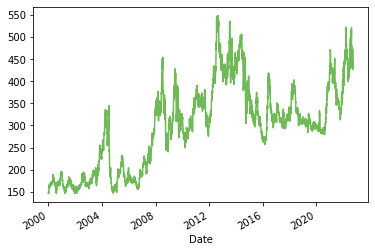

In [27]:
grains['SOYBEAN MEAL'].plot(color='#6fb957');

# SOYBEAN OIL



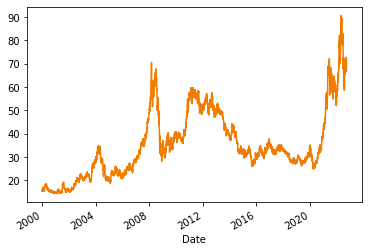

In [28]:
grains['SOYBEAN OIL'].plot(color='#f17c00');

<AxesSubplot:xlabel='Date'>

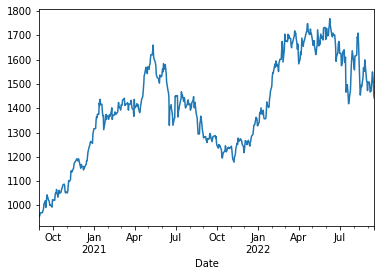

In [21]:
soybeans_test.index = pd.PeriodIndex(soybeans_test.index, freq='D')
soybeans_test.plot()